In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from particle import Particle

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_D0 = 1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [5]:
def drawOnCMSCanvas(dobj, opt = None, tag=''):
    c = rt.TCanvas('c'+tag, 'c'+tag, 50, 50, 800, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    
    if dobj.__class__ == rt.RooPlot:
        dobj.Draw()
    elif dobj[0].__class__ in [rt.TH1D, rt.TH2D]:
        for i, o in enumerate(dobj):
            do = ''
            if not (opt is None):
                if opt == 'same':
                    if i>0:
                        do = 'SAME'
                else:
                    do = opt[i]
            o.Draw(do)
    else:
        print 'Class not recognized'
        raise
        
    
    CMS_lumi.CMS_lumi(c, -1, 0)
    c.obj = dobj
    c.Draw()
    return c

In [6]:
def extarct(t, branches = []):
    if len(branches) == 0:
        branches = t.keys()
    l = {}
    for k in branches:
        print 'Loading branch', k
        m = []
        for i, e in enumerate(t.array(k)):
            m += list(e)
        l[k] = np.array(m)
    
    return l

In [7]:
def extarct_multiple(fname, branches = []):
    if len(branches) == 0:
        print 'Must give a branches list'
    l = {}
    for b in branches:
        l[b] = []
    
    flist = glob(fname)
    
    for i,f in enumerate(flist):
        t = ur.open(f)
        if 'outA;1' in t.keys():
            t=t['outA']['Tevts']
            for k in branches:
                
                for i, e in enumerate(t.array(k)):
                    l[k] += list(e)
    
    for b in branches:
        l[b] = np.array(l[b])
    return l

In [8]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [9]:
tMC = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates.root')['outA']['Tevts']
print tMC.keys(), '\n\n'
branches = tMC.keys()[10:]
for b in np.sort(branches):
    print b

['n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxMu', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pis_E', 'pis_P', 'pis_eta', 'pis_phi', 'pis_pt', 'q2', 'sigd_vtxD0pis_vtxMu', 'sigd_vtxkpi_vtxMu', 'sigdca_D0pis_vtxMu', 'sigdca_kpi_vtxMu'] 


B_E
B_P
B_eta
B_phi
B_pt
D0_E
D0_P
D0_eta
D0_phi
D0_pt
Dst_E
Dst_P
Dst_eta
Dst_phi
Dst_pt
Est_mu
K_E
K_P
K_eta
K_phi
K_pt
M2_miss
chi2_D0pis
chi2_MuDst
chi2_kpi
cos_D0pis_vtxMu
cos_MuDst_vtxMu
cos_kpi_vtxMu
d_vtxD0pis_vtxMu
d_vtxkpi_vtxMu
dca_D0pis_vtxMu
dca_kpi_vtxMu
mass_D0pis
mass_MuDst
mass_kpi
pi

In [10]:
fn = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0'
fn += '/B02DstMu_candidates/out*.root'
dMC = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC['mass_kpi'].shape[0]

Number of candidates: 5401


In [28]:
fn = '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0'
fn += '/B02DstMu_candidates/out*.root'
dMC_tau = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC_tau['mass_kpi'].shape[0]

Number of candidates: 4245


In [23]:
fn = '../data/cmsRD/Run2018D/B02DstMu_190501_BPH*.root'
dRD = extarct_multiple(fn, branches)
print 'Number of candidates:', dRD['mass_kpi'].shape[0]

Number of candidates: 255209


# Cuts declaration

In [14]:
cut = {}
cut['cos_MuDst_vtxMu'] = ['>', 0.98]
# cut['chi2_D0pis'] = ['<', 3.84]
# cut['d_vtxkpi_vtxMu'] = ['>', 0.03]
# cut['sigdca_kpi_vtxMu'] = ['>', 2.]

In [15]:
np.max(dMC['chi2_D0pis'])

6.634117

In [16]:
sps.chi2.cdf(3.84, 1)

0.9499564787512949

In [17]:
def createSel(d, cut):
    sel = np.ones_like(d[cut.keys[0]], dtype=bool)
    for k, v in cut.iteritems():
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
    return sel

## MC only

In [18]:
dMC['mass_D0pis']

array([2.0098155, 2.0101278, 2.010078 , ..., 2.0114744, 2.0101352,
       2.0108001], dtype=float32)

<ROOT.TLine object ("TLine") at 0x7f8088db9ad0>

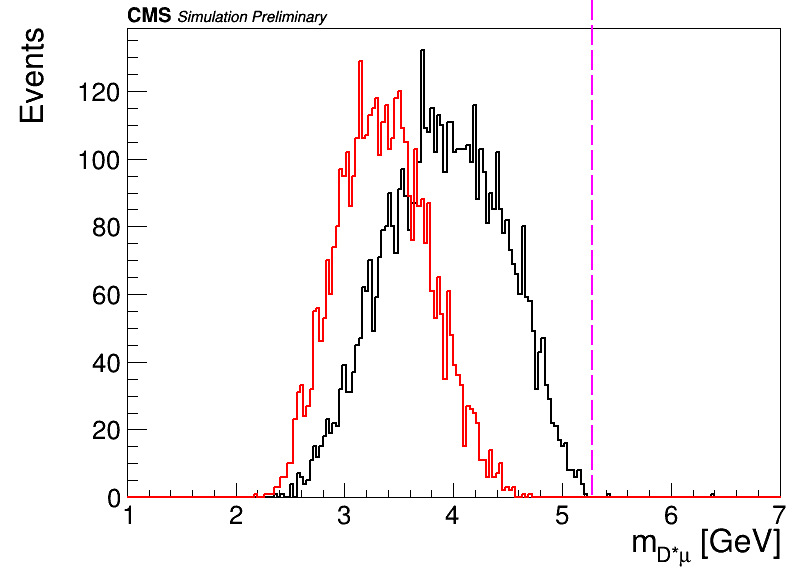

In [29]:
h = create_TH1D(dMC['mass_MuDst'], axis_title=['m_{D*#mu} [GeV]', 'Events'], binning=[200,1,7])
h_tau = create_TH1D(dMC_tau['mass_MuDst'], binning=h.binning)
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h, h_tau], 'same')
cl.DrawLine(m_B0, 0, m_B0, 1800)

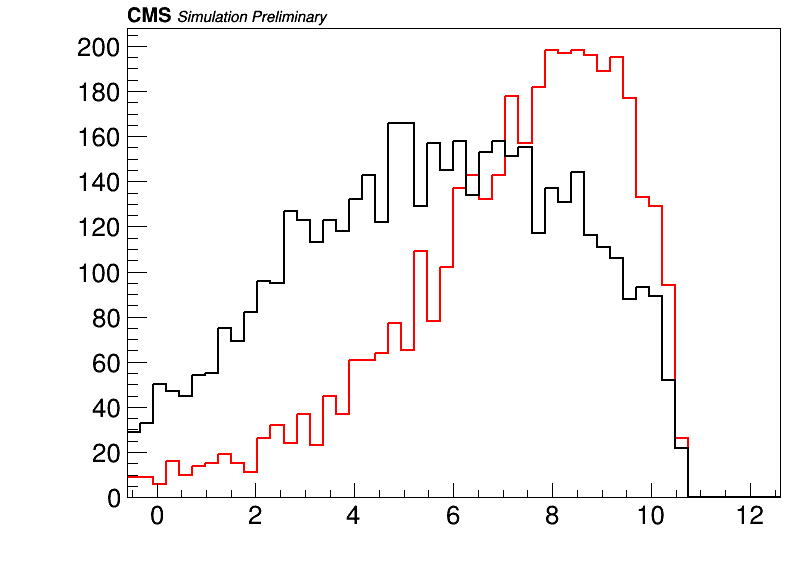

In [52]:
h = create_TH1D(dMC['q2'], axis_title=['q^{2} [GeV^{2}]', 'Events'], binning=[50, -0.6, 12.6])
h_tau = create_TH1D(dMC_tau['q2'], binning=h.binning)
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h_tau, h], 'same')

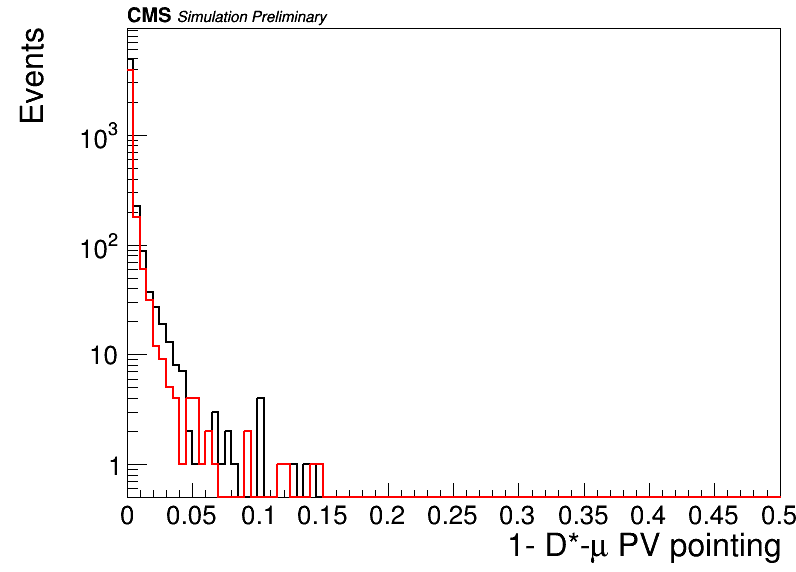

In [30]:
h = create_TH1D(1-dMC['cos_MuDst_vtxMu'], axis_title=['1- D*-#mu PV pointing', 'Events'], binning=[100,0.,0.5])
h_tau = create_TH1D(1-dMC_tau['cos_MuDst_vtxMu'], binning=h.binning)
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h, h_tau], 'same')
c.SetLogy()

In [31]:
binning_q2 = np.linspace(-0.4, 12.6, 5, True)
N_q2bins = binning_q2.shape[0]-1
print binning_q2

xAx_title = {}
xAx_title['M2_miss'] = 'm^{2}_{miss} [GeV^{2}]'
xAx_title['Est_mu'] = 'E*_{#mu} [GeV]'

N_var = len(binning.keys())

def q2_sel(arr, q2_l, q2_h, vname='q2'):
    return np.logical_and(arr[vname] > q2_l, arr[vname] < q2_h)

[-0.4   2.85  6.1   9.35 12.6 ]


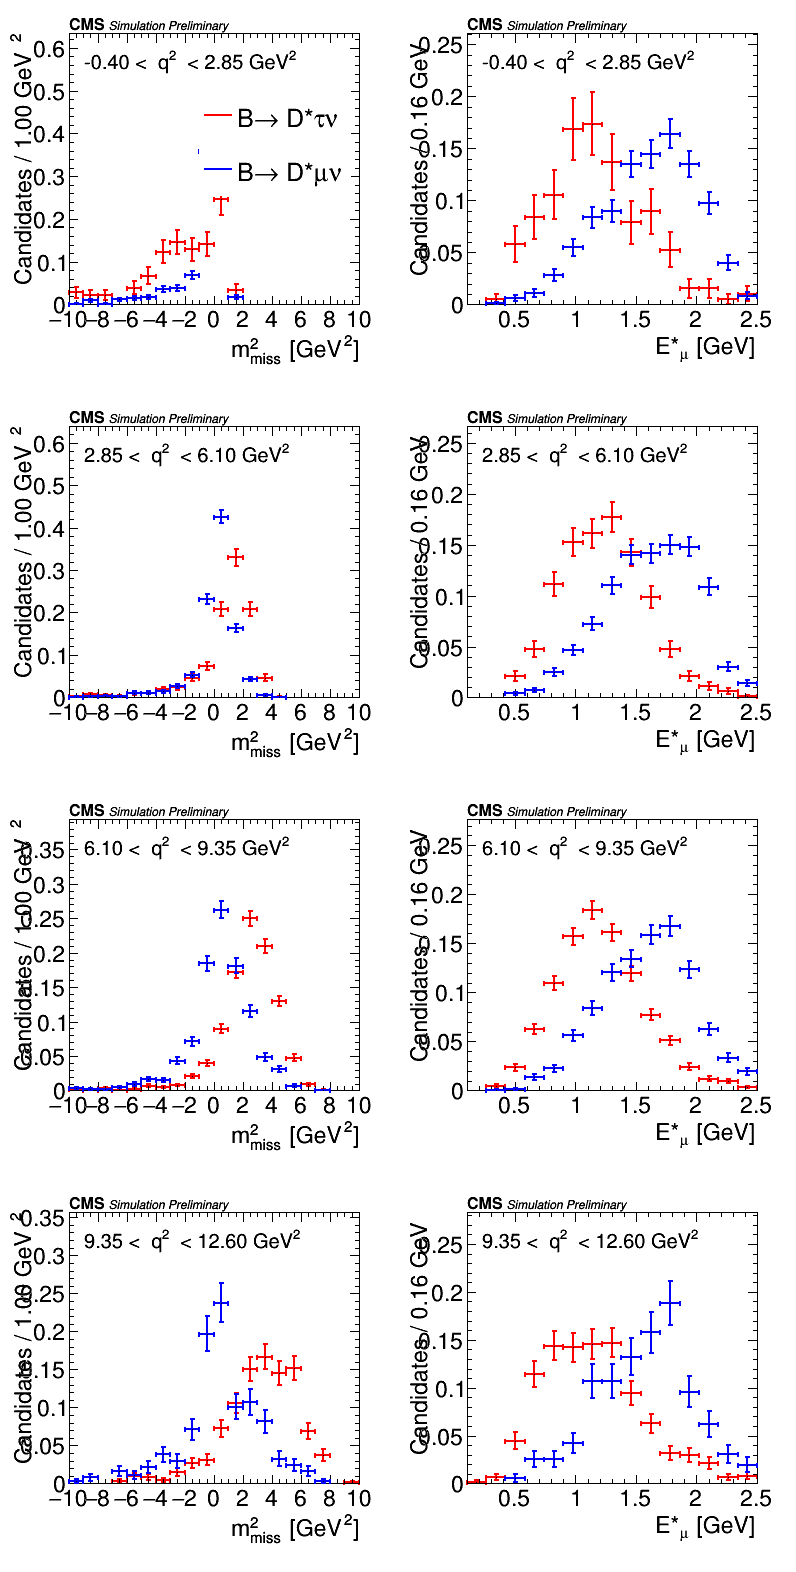

In [43]:
binning = {}
binning['M2_miss'] = [40/2, -10, 10]
binning['Est_mu'] = [30/2, 0.10, 2.500]

canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_var*400, 400*N_q2bins)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_var, N_q2bins)

CMS_lumi.extraText = "        Simulation Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

for i_q2 in range(N_q2bins):
    q2_l = binning_q2[i_q2]
    q2_h = binning_q2[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)

    for i_v, vark in enumerate(vars_to_plot):
        h_bname = 'h_{}_{}'.format(i_q2, i_v)

        h_dic = {}
        for k, t in zip(['mu', 'tau'], [dMC, dMC_tau]):
            aux = t[vark][q2_sel(t, q2_l, q2_h)]
            h_dic[k] = create_TH1D(aux, h_bname+'_aux_'+k, binning=binning[vark])
#             h_dic[k].Scale(overall_scale_factor)

#         h_dic['tau'].Scale(0.3*0.17) #R(D*)*Br(tau->mu)


        h = rt.TH1D(h_bname+'_tau', h_bname+'_tau', binning[vark][0], binning[vark][1], binning[vark][2])
        h.Add(h_dic['tau'])#, h_dic['mu']) #Just because we want to show them separate
        h.SetLineColor(2)
        h.GetXaxis().SetTitle(xAx_title[vark])
        h.GetXaxis().SetTitleSize(0.07)
        h.GetXaxis().SetLabelSize(0.07)
        h.GetYaxis().SetTitleOffset(1.14)
        h.GetXaxis().SetTitleOffset(1.1)
        h.GetYaxis().SetTitleSize(0.07)
        h.GetYaxis().SetLabelSize(0.07)
        iunits = xAx_title[vark].find('[') + 1
        h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(1)) + xAx_title[vark][iunits:-1])

        h2 = h_dic['mu'].Clone(h_bname+'_mu')
        h2.SetLineColor(4)

        i_pad = i_q2*N_var + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.08)

        # Normalize them to unity....
        h.Scale(1./h.Integral())
        h2.Scale(1./h2.Integral())
        h.GetYaxis().SetRangeUser(0, 1.5*np.max([x.GetMaximum() for x in [h, h2]]))


        h.Draw('E1')
        h2.Draw('E1SAME')

        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.2, 0.85, q2_txt)

        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)

        if 'ip' in vark:
            maxs = [x.GetMaximum() for x in [h, h2]]
            h.GetYaxis().SetRangeUser(1e-4, 1.5*np.max(maxs))
            pad.SetLogy()

        if i_pad == 1:
            leg = rt.TLegend(0.5, 0.5, 0.9, 0.8)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(0)
            leg.SetBorderSize(0)
            leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'l')
            leg.AddEntry(h2, 'B#rightarrow D*#mu#nu', 'l')
            leg.Draw()

        donotdelete.append([h, h2])

canvas.Draw()
# canvas.SaveAs('/Users/olmo/Desktop/Vars_wRefittedMuDstandDstMassConst.png')

## RD only

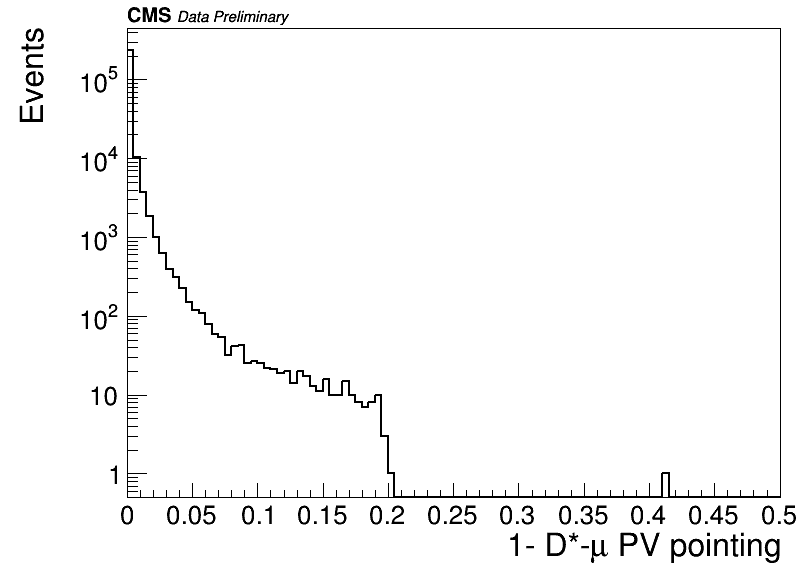

In [25]:
h = create_TH1D(1-dRD['cos_MuDst_vtxMu'], axis_title=['1- D*-#mu PV pointing', 'Events'], binning=[100,0.,0.5])
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas([h])
c.SetLogy()

<ROOT.TLine object ("TLine") at 0x7f8085ec5a30>

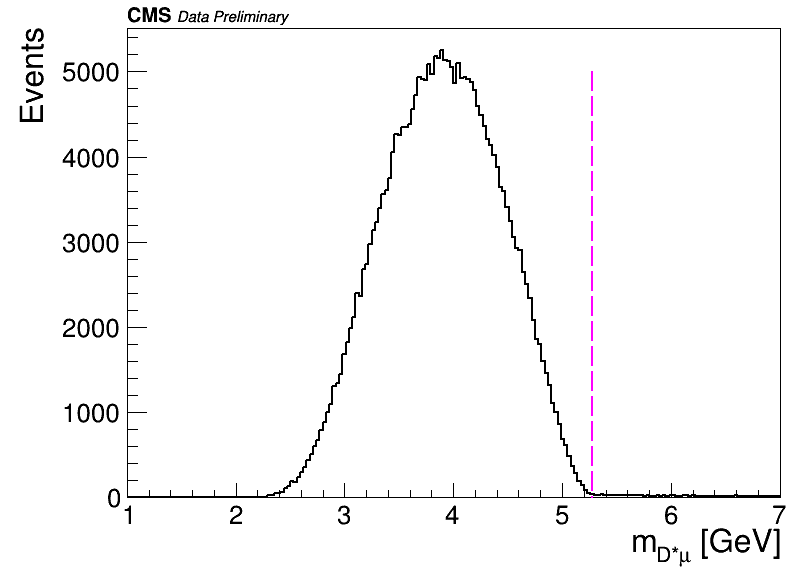

In [34]:
h = create_TH1D(dRD['mass_MuDst'], axis_title=['m_{D*#mu} [GeV]', 'Events'], binning=[200,1,7])
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas([h])
cl.DrawLine(m_B0, 0, m_B0, 5000)

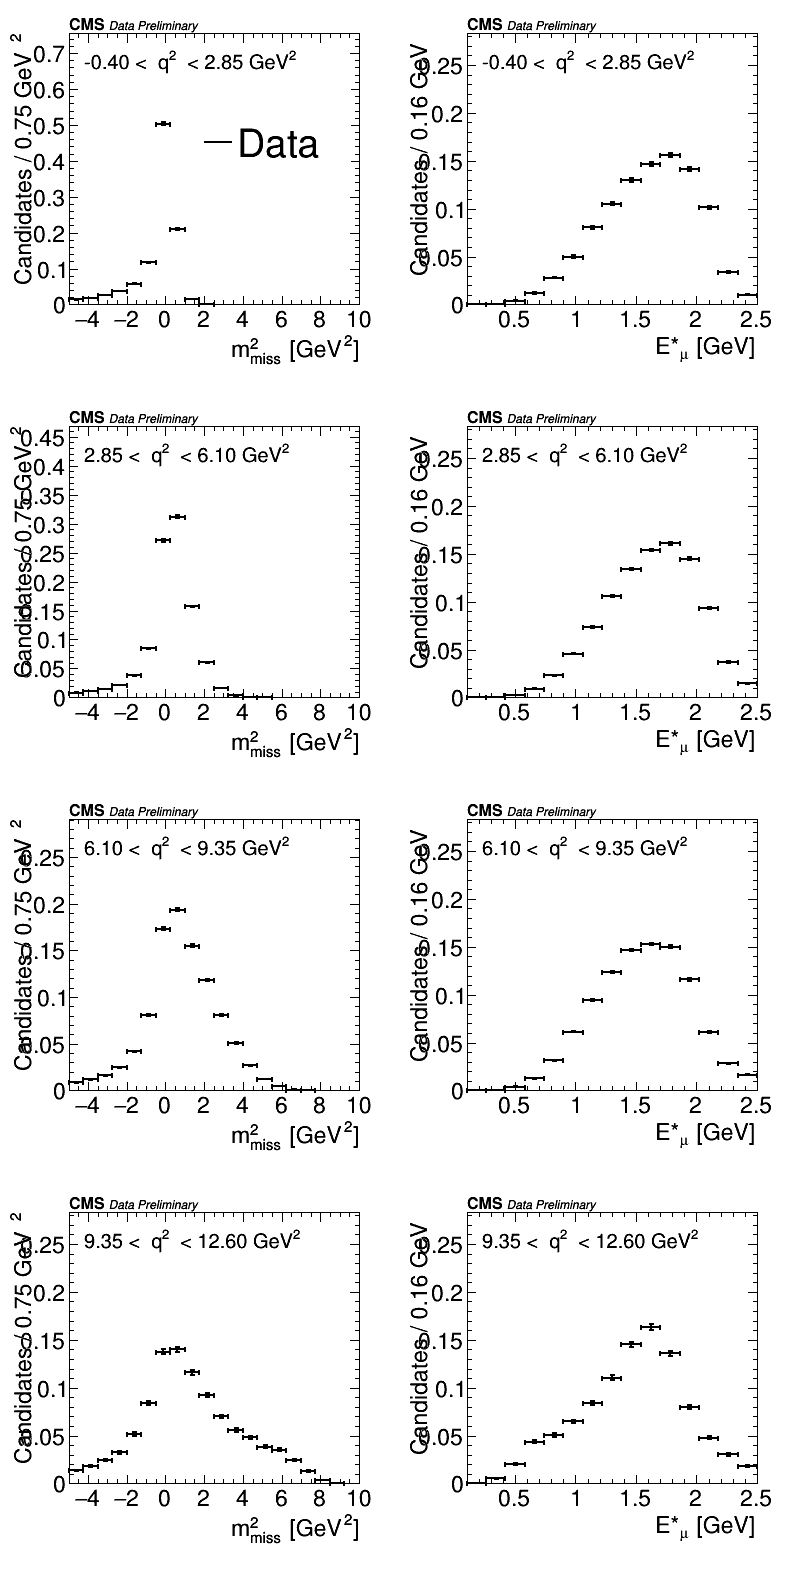

In [42]:
binning = {}
binning['M2_miss'] = [40/2, -5, 10]
binning['Est_mu'] = [30/2, 0.10, 2.500]

canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_var*400, 400*N_q2bins)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_var, N_q2bins)

CMS_lumi.extraText = "        Data Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

for i_q2 in range(N_q2bins):
    q2_l = binning_q2[i_q2]
    q2_h = binning_q2[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)

    for i_v, vark in enumerate(vars_to_plot):
        h_bname = 'h_{}_{}'.format(i_q2, i_v)

        h_dic = {}
        for k, t in zip(['data'], [dRD]):
            aux = t[vark][q2_sel(t, q2_l, q2_h)]
            h_dic[k] = create_TH1D(aux, h_bname+'_aux_'+k, binning=binning[vark])
#             h_dic[k].Scale(overall_scale_factor)

#         h_dic['tau'].Scale(0.3*0.17) #R(D*)*Br(tau->mu)


        h = rt.TH1D(h_bname+'_data', h_bname+'_data', binning[vark][0], binning[vark][1], binning[vark][2])
        h.Add(h_dic['data'])#, h_dic['mu']) #Just because we want to show them separate
        h.SetLineColor(1)
        h.GetXaxis().SetTitle(xAx_title[vark])
        h.GetXaxis().SetTitleSize(0.07)
        h.GetXaxis().SetLabelSize(0.07)
        h.GetYaxis().SetTitleOffset(1.14)
        h.GetXaxis().SetTitleOffset(1.1)
        h.GetYaxis().SetTitleSize(0.07)
        h.GetYaxis().SetLabelSize(0.07)
        iunits = xAx_title[vark].find('[') + 1
        h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(1)) + xAx_title[vark][iunits:-1])

        i_pad = i_q2*N_var + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.08)

        # Normalize them to unity....
        h.Scale(1./h.Integral())
        h2.Scale(1./h2.Integral())
        h.GetYaxis().SetRangeUser(0, 1.5*np.max([x.GetMaximum() for x in [h, h2]]))


        h.Draw('E1')

        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.2, 0.85, q2_txt)

        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)

        if 'ip' in vark:
            maxs = [x.GetMaximum() for x in [h, h2]]
            h.GetYaxis().SetRangeUser(1e-4, 1.5*np.max(maxs))
            pad.SetLogy()

        if i_pad == 1:
            leg = rt.TLegend(0.5, 0.5, 0.9, 0.8)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(0)
            leg.SetBorderSize(0)
            leg.AddEntry(h, 'Data', 'l')
            leg.Draw()

        donotdelete.append([h, h2])

canvas.Draw()